# Description

This notebook calculates the Bayesian credibility (credence) for the hypothesis that the binomial single trial success probability is greater or equal to ```p_success_hypothesis```, given the number of conducted tests ```n_trials``` and the number of successful tests ```n_successes``` out of these, using a uniform prior distribution.

This notebook tells you how much belief you can put into the idea that your single trial success probability is at least ```p_success_hypothesis``` after having done a test with ```n_trials``` trials of which ```n_successes``` were successful. This result depends on a so-called prior distribution that models your belief in different possible single trial success probabilities before the test. By default we choose a uniform prior, since this does not skew the results (the maximum belief will be for exactly the success rate of your test run).

__Note__
1. All probabilities are given as numbers between 0 and 1, where 0 represents "never" and 1 represents 100% certainty.
2. The calculated degree of belief is __NOT__ conservative. It depends on the chosen prior and can be both too high and too low.

# Parameters

In [22]:
n_trials = 100 #number of trials conducted
n_successes = 92 #number of successful trials
p_success_hypothesis = 0.9

round_to_digits = 4

assert isinstance(n_trials, int) and n_trials >= 0
assert isinstance(n_successes, int) and 0 <= n_successes <= n_trials
assert isinstance(p_success_hypothesis, float) and 0 <= p_success_hypothesis <= 1
assert isinstance(round_to_digits, int) and round_to_digits >= 1

# Evaluation

You have conducted 0 test of which 0 were successful
The credibility of the hypothesis is 0.1 that the success probability of a single trial is at least 0.9


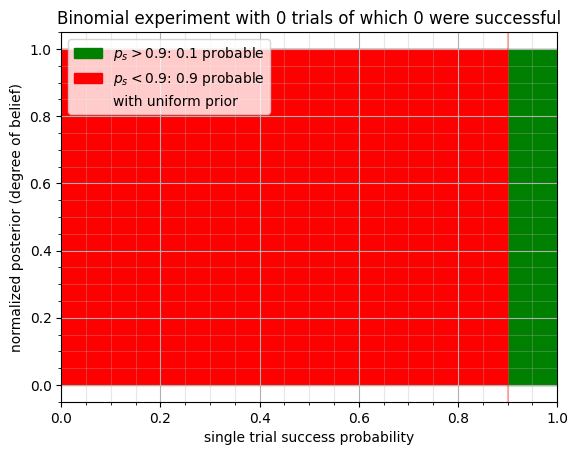

In [23]:
import matplotlib.pyplot as plt
import mpmath as mp
import numpy as np
from scipy import integrate

mp.mp.dps = 50 #use 50 decimal digits precision in mpmath calculations

def posterior_prob_binom_p(p, n_trials, n_successes, prior):
    return mp.power(mp.mpf(p), n_successes) * mp.power(mp.mpf(1-p), (n_trials-n_successes)) * prior(p)

posterior_prob_binom_p_vectorized = np.vectorize(posterior_prob_binom_p)

#split the integral into constant and non-constant parts and prescale so numerical integration does not fail due to sharp peak for large n_trial
def integrate_posterior_prob_binom_p_norm(n_trials, n_successes, prior, bounds):
    mean = (n_successes+1) / (n_trials+1)
    std_dev = ( (n_successes+1)*(n_trials-n_successes+1) / ((n_trials+1)**2*(n_trials+2)) )**0.5
    prescale = 1/posterior_prob_binom_p(mean,n_trials, n_successes, prior)
    prior_prescaled = lambda p: prior(p) * prescale
    
    norm = 0
    if bounds[0] < mean-3*std_dev:
        norm += integrate.quad(posterior_prob_binom_p, max(0, bounds[0]), min(mean-3*std_dev, bounds[1]), args=(n_trials, n_successes, prior_prescaled))[0]
    if bounds[0] < mean and bounds[1] >= mean-3*std_dev:
        norm += integrate.quad(posterior_prob_binom_p, max(mean-3*std_dev, bounds[0]), min(mean, bounds[1]), args=(n_trials, n_successes, prior_prescaled))[0]
    if bounds[0] < mean+3*std_dev and bounds[1] >= mean:
        norm += integrate.quad(posterior_prob_binom_p, max(mean, bounds[0]), min(mean+3*std_dev, bounds[1]), args=(n_trials, n_successes, prior_prescaled))[0]
    if bounds[0] < 1 and bounds[1] >= mean+3*std_dev:
        norm += integrate.quad(posterior_prob_binom_p, max(mean+3*std_dev, bounds[0]), min(1, bounds[1]), args=(n_trials, n_successes, prior_prescaled))[0]
        
    return norm / prescale

xlim_lo = 0.0 #change plot range here
xlim_hi = 1.0
p = np.linspace(xlim_lo, xlim_hi, 1001)

prior = lambda p: 1
norm = integrate_posterior_prob_binom_p_norm(n_trials, n_successes, prior, [0, 1])
posterior_probs = posterior_prob_binom_p_vectorized(p, n_trials, n_successes, prior=prior) / norm
hypothesis_credibility = integrate_posterior_prob_binom_p_norm(n_trials, n_successes, prior, [p_success_hypothesis, 1]) / norm
hypothesis_credibility_rounded = mp.nstr(hypothesis_credibility, round_to_digits)
null_hypothesis_credibility_rounded = mp.nstr(1-hypothesis_credibility, round_to_digits)
print('You have conducted {} test of which {} were successful'.format(n_trials, n_successes))
print('The credibility of the hypothesis is {} that the success probability of a single trial is at least {}'.format(hypothesis_credibility_rounded, p_success_hypothesis))

plt.fill_between(p[p>=p_success_hypothesis], posterior_probs.astype(float)[p>=p_success_hypothesis], color='green', label='$p_s > {}$: {} probable'.format(p_success_hypothesis, hypothesis_credibility_rounded))
plt.fill_between(p[p<p_success_hypothesis], posterior_probs.astype(float)[p<p_success_hypothesis], color='red', label='$p_s < {}$: {} probable'.format(p_success_hypothesis, null_hypothesis_credibility_rounded))
plt.plot(p, posterior_probs, color='black', alpha=0, label='with uniform prior')
plt.axvline(p_success_hypothesis, 0, 1, color='red', alpha=0.3)

plt.gca().set_title('Binomial experiment with {} trials of which {} were successful'.format(n_trials, n_successes))
plt.gca().set_xlabel('single trial success probability')
plt.gca().set_ylabel('normalized posterior (degree of belief)')
plt.gca().tick_params(axis='x', which='minor', bottom=True)
plt.gca().minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', alpha=0.3);
plt.legend(loc='upper left')

plt.gca().set_xlim([xlim_lo, xlim_hi]);